In [ ]:
!pip install stanza
!pip install allennlp
!pip install transformers-interpret

In [2]:
import pandas as pd
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import BertTokenizer, RobertaTokenizer, BertModel, RobertaModel, BertForSequenceClassification, RobertaForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AdamW,get_linear_schedule_with_warmup
import numpy as np
import torch
from scipy.special import softmax
import csv
import urllib.request
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from wordcloud import WordCloud
import requests
from PIL import Image
from io import BytesIO

import spacy
import tokenizers

import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import random

import stanza
import spacy
from allennlp.modules.elmo import Elmo, batch_to_ids

import html
import re
import string
from copy import deepcopy

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import MultiLabelClassificationExplainer, SequenceClassificationExplainer

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
train_df = pd.read_csv('/kaggle/input/eurecom-aml-2023-challenge-3/train.csv')
test_df = pd.read_csv('/kaggle/input/eurecom-aml-2023-challenge-3/test.csv')

In [4]:
# RUN THIS CELL IF YOU WANT THE EXTRACTED TEXT 
span_train_df = pd.read_csv('/kaggle/input/elmodataset2/new_train_set.csv')
span_test_df = pd.read_csv('/kaggle/input/elmodataset2/new_test_set.csv')

In [7]:
for i in range(40):
    print(train_df['text'].iloc[i])
    print(train_df['selected_text'].iloc[i])
    print(span_train_df['text'].iloc[i])
    print()

 good luck with your auction
good luck with your auction
good luck with your auction

Hmm..You can`t judge a book by looking at its cover
Hmm..You can`t judge a book by looking at its cover
Hmm .. You can`t judge a book by looking at its cover

 Hello, yourself. Enjoy London. Watch out for the Hackneys. They`re mental.
They`re mental.
, yourself . Enjoy London . Watch out for the Hackneys . They`re mental .

  We can`t even call you from belgium  sucks
m  suck
sucks

not so good mood..
not so good mood..
not so good mood ..

Jumping im the shower after a long day of work  it shall feel ahmazing I CAN MATH!
ahmazing
a long day of work   it shall feel ahmazing I CAN MATH !

 OK! Oops sorry
sorry
! Oops sorry

says Finally, Im home.  http://plurk.com/p/rr121
says Finally, Im home.
says Finally , I m home .

I am native, not french ! I hate this ! !  ! Trying to find animals in french, I SUCK, SOMEONE HELP PLEEEEEASE  ? Alone- Allison Iraheta ?
SUCK,
I am native , not french ! I hate this 

In [5]:
sentiment_dictionary = {
    'negative' : 0,
    'neutral' : 1,
    'positive' : 2
}

train_df['sentiment'] = train_df['sentiment'].map(sentiment_dictionary)

# Baseline with Pre-trained model sentiment analysis

In [ ]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}-latest"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

texts = test_df['text']
ids = test_df['textID']
# labels = train_df['sentiment']

In [ ]:
y_pred = []
list_ids = []

for text in tqdm_notebook(texts):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    y_pred.append(np.argmax(scores) - 1)

In [ ]:
submission_df = pd.DataFrame()
submission_df['textID'] = list_ids
submission_df['sentiment'] = y_pred

In [ ]:
submission_df.to_csv("/kaggle/working/submission_baseline_latest.csv", index=False)

# Our Work

## Some preprocessing

In [8]:
HASHTAG_REGEX = r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"
USER_TAGS_REGEX = r"(?:@[\w_]+)"
URL_REGEX = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
REPEATED_PUNCTUATION_REGEX = r'(?<=[^!.,>$%&-][!.,>$%&-])[!.,>$%& -]+(?<! )'

def replace_punct(match):
    match = match.group()
    return match[0] + (" " if " " in match else "")

def extract_words(input_string):
    words = []
    substrings = input_string.split()
    for substring in substrings:
        word = [char for char in substring if char.isalpha()]
        word = ''.join(word)
        if word:
            words.append(word)
    return words


def clean_text(x):
    new_text = html.unescape(x)
    
    # remove repeated punctuation
    new_text = re.sub(REPEATED_PUNCTUATION_REGEX, replace_punct, new_text, 0)
    
    # remove user tags, urls and # symbol
    user_tags = re.findall(USER_TAGS_REGEX, new_text)
    urls = [''.join(i) for i in re.findall(URL_REGEX, x)]
    for token in user_tags + urls + ['#']:
        new_text = new_text.replace(token, '')
    
    # remove repeated characters in words
    new_text = re.sub(r'(.)\1+', r'\1\1', new_text)     
    
    # trim whitespaces
    new_text = re.sub(r'\s+', ' ', new_text)
    
    # find misspelled words
    #
    # misspelled = spell.unknown(extract_words(new_text))
    # for word in misspelled:
    #     corr = spell.correction(word)
    #     if corr is not None:
    #        new_text = new_text.replace(word, corr)
    
    return new_text

# spell = spellchecker.SpellChecker()

clean_train_df = deepcopy(train_df)
clean_train_df["text"] = train_df["text"].map(lambda x: clean_text(x))

clean_train_df.head()

,text,sentiment
0,good luck with your auction,2
1,Hmm .. You can`t judge a book by looking at it...,1
2,", yourself . Enjoy London . Watch out for the ...",0
3,sucks,0
4,not so good mood ..,0


## Data Exploration

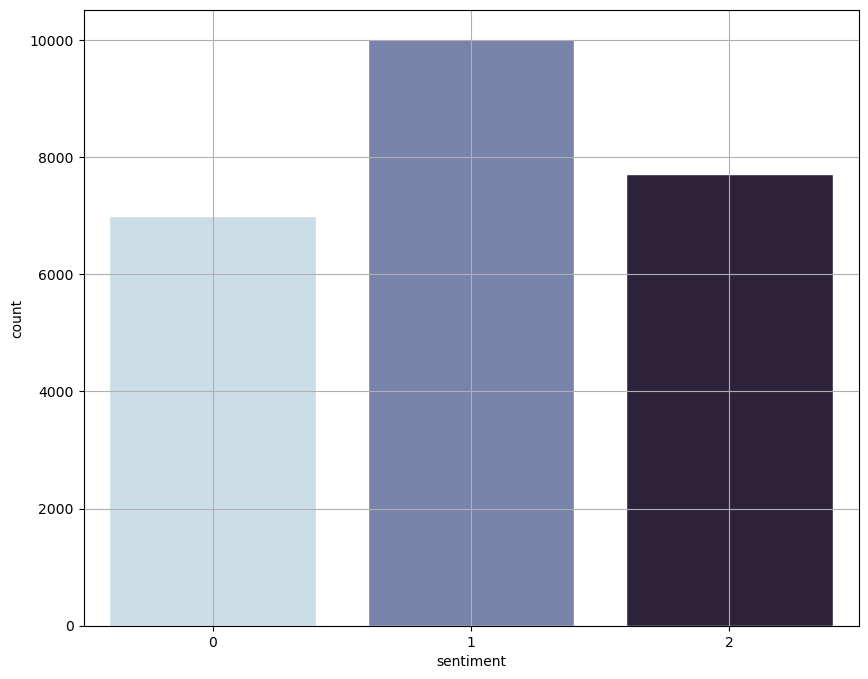

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, _ = plt.subplots(figsize=(10, 8))

sentiment = clean_train_df['sentiment']

sns.set_style("whitegrid")
sns.countplot(x=sentiment, palette='ch:s=.25,rot=-.25')

plt.grid(True)
plt.show()

In [16]:
positive_tweets = clean_train_df[train_df['sentiment'] == 2]
neutral_tweets = clean_train_df[train_df['sentiment'] == 1]
negative_tweets = clean_train_df[train_df['sentiment'] == 0]

image_url = 'https://1000logos.net/wp-content/uploads/2017/06/Twitter-symbol.jpg'

response = requests.get(image_url)
tweet_mask = np.array(Image.open(BytesIO(response.content)))

palette = sns.color_palette("dark:#5A9_r", as_cmap=True)

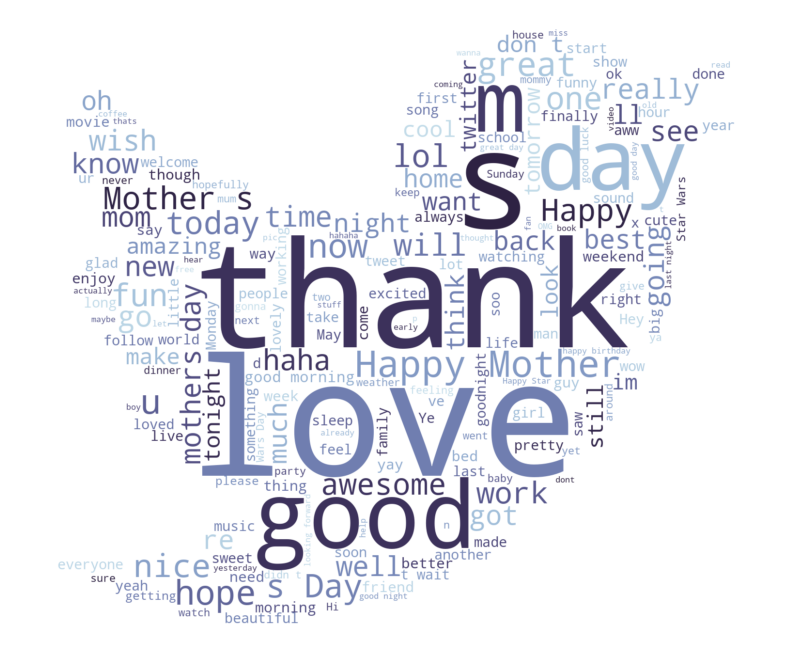

In [17]:
text = ' '.join(positive_tweets['text'])

palette = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

wordcloud = WordCloud(mask=tweet_mask, background_color='white', colormap=palette)

# Generate the word cloud
wordcloud.generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

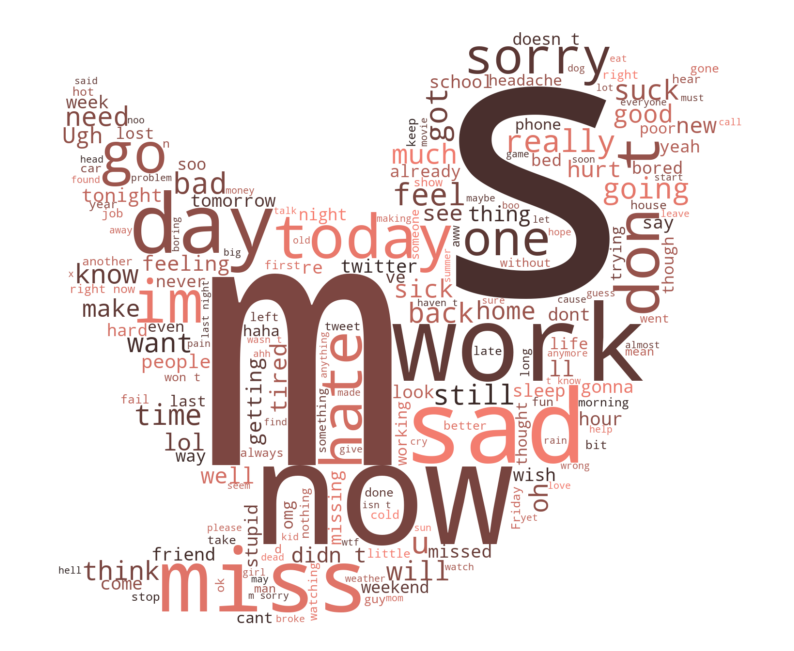

In [18]:
text = ' '.join(negative_tweets['text'])

palette = sns.color_palette("dark:salmon_r", as_cmap=True)

wordcloud = WordCloud(mask=tweet_mask, background_color='white', colormap=palette)

# Generate the word cloud
wordcloud.generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# BERT Loop

In [9]:
from transformers import AdamW,get_linear_schedule_with_warmup

models = {
    'bert' : [BertForSequenceClassification, BertTokenizer, 'bert-base-uncased'],
    'roberta' : [RobertaForSequenceClassification, RobertaTokenizer, 'roberta-base'],
    'distil-bert' : [DistilBertForSequenceClassification, DistilBertTokenizer, 'distilbert-base-uncased']
  }

selected_model = 'roberta'
model_class = models[selected_model][0]
tokenizer_class = models[selected_model][1]
pretrained_weights = models[selected_model][2]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
n_gpu = torch.cuda.device_count()

model = model_class.from_pretrained(pretrained_weights, 
                                    num_labels=3)

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

labels = clean_train_df['sentiment']
text = clean_train_df['text']

X_train, X_test, y_train, y_test = train_test_split(text, labels, stratify=labels)

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
train_labels = torch.tensor(y_train.values)

eval_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)
eval_labels = torch.tensor(y_test.values)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']), 
                                               torch.tensor(train_encodings['attention_mask']), 
                                               train_labels)
eval_dataset = torch.utils.data.TensorDataset(torch.tensor(eval_encodings['input_ids']), 
                                              torch.tensor(eval_encodings['attention_mask']), 
                                              eval_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=32, shuffle=False)

model.to(device)

learning_rate = 1e-5
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(),lr = 1e-5,eps = 1e-8)
n_epochs = 5
scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps = 0,
            num_training_steps = len(train_loader)*n_epochs 
            )

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should pr

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
best_score = float('-inf')
best_model = None

for epoch in range(n_epochs):
    print("EPOCH {}/{}".format(epoch+1, n_epochs))
    loss_epoch = 0.0
    i = 0
    model.train()
    
    for batch in tqdm(train_loader):
        i += 1
        model.zero_grad()
        inputs = {
                  'input_ids' : batch[0].to(device),
                  'attention_mask' : batch[1].to(device),
                  'labels' : batch[2].to(device)
              }
        # labels = batch[2].to(device)
        outputs = model(**inputs)
        loss = outputs.loss
        # loss = criterion(outputs, labels)
        loss.backward()
        loss_epoch += loss.item()
        
        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
        
        optimizer.step()
        scheduler.step()
        
        if i % 50 == 0 and i != 0:
            print("ITER: {} WITH LOSS: {}".format(i, loss_epoch))
            loss_epoch = 0.0
            
       
    print("START EVALUATING...")
    model.eval()
    
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            inputs = {
                'input_ids' : batch[0].to(device),
                'attention_mask' : batch[1].to(device),
                'labels' : batch[2].to(device)
            }

            y_true.extend(batch[2])

            outputs = model(**inputs)[1].detach().cpu().numpy()

            y_pred.extend(np.argmax(outputs, axis=1))
        
    epoch_score = f1_score(y_true, y_pred, average='macro')
    
    if epoch_score > best_score:
        best_model = model
        best_score = epoch_score
    
    print(f"GOT AS A SCORE: {epoch_score}")

EPOCH 1/5


  0%|          | 0/580 [00:00<?, ?it/s]

/tmp/ipykernel_28/1594100665.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


ITER: 50 WITH LOSS: 54.55446493625641
ITER: 100 WITH LOSS: 43.516217052936554
ITER: 150 WITH LOSS: 33.84275075793266
ITER: 200 WITH LOSS: 31.73671841621399
ITER: 250 WITH LOSS: 30.634294360876083
ITER: 300 WITH LOSS: 28.900665521621704
ITER: 350 WITH LOSS: 27.725819617509842
ITER: 400 WITH LOSS: 29.763294905424118
ITER: 450 WITH LOSS: 27.475391685962677
ITER: 500 WITH LOSS: 26.850147277116776
ITER: 550 WITH LOSS: 25.88717210292816
START EVALUATING...


  0%|          | 0/194 [00:00<?, ?it/s]

GOT AS A SCORE: 0.7982646989611276
EPOCH 2/5


  0%|          | 0/580 [00:00<?, ?it/s]

/tmp/ipykernel_28/1594100665.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


ITER: 50 WITH LOSS: 24.440372690558434
ITER: 100 WITH LOSS: 23.41562730073929
ITER: 150 WITH LOSS: 25.833256274461746
ITER: 200 WITH LOSS: 24.153945714235306
ITER: 250 WITH LOSS: 25.343823850154877
ITER: 300 WITH LOSS: 24.906901717185974
ITER: 350 WITH LOSS: 24.60599747300148
ITER: 400 WITH LOSS: 23.304282799363136
ITER: 450 WITH LOSS: 24.387789994478226
ITER: 500 WITH LOSS: 23.5480894446373
ITER: 550 WITH LOSS: 26.096886098384857
START EVALUATING...


  0%|          | 0/194 [00:00<?, ?it/s]

GOT AS A SCORE: 0.8084450916998805
EPOCH 3/5


  0%|          | 0/580 [00:00<?, ?it/s]

/tmp/ipykernel_28/1594100665.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


ITER: 50 WITH LOSS: 22.63344743847847
ITER: 100 WITH LOSS: 21.526101633906364
ITER: 150 WITH LOSS: 20.258639708161354
ITER: 200 WITH LOSS: 21.03660187125206
ITER: 250 WITH LOSS: 22.28887929022312
ITER: 300 WITH LOSS: 21.82364024221897
ITER: 350 WITH LOSS: 21.3414546251297
ITER: 400 WITH LOSS: 20.69755245745182
ITER: 450 WITH LOSS: 22.604559019207954
ITER: 500 WITH LOSS: 20.57051418721676
ITER: 550 WITH LOSS: 21.360501989722252
START EVALUATING...


  0%|          | 0/194 [00:00<?, ?it/s]

GOT AS A SCORE: 0.8084421591754163
EPOCH 4/5


  0%|          | 0/580 [00:00<?, ?it/s]

/tmp/ipykernel_28/1594100665.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


ITER: 50 WITH LOSS: 19.97753845155239
ITER: 100 WITH LOSS: 18.843482330441475
ITER: 150 WITH LOSS: 19.89569281041622
ITER: 200 WITH LOSS: 19.812328591942787
ITER: 250 WITH LOSS: 17.37896740436554
ITER: 300 WITH LOSS: 17.770076528191566
ITER: 350 WITH LOSS: 20.533655740320683
ITER: 400 WITH LOSS: 19.220509216189384
ITER: 450 WITH LOSS: 20.34913481771946
ITER: 500 WITH LOSS: 18.82759277522564
ITER: 550 WITH LOSS: 19.040324807167053
START EVALUATING...


  0%|          | 0/194 [00:00<?, ?it/s]

GOT AS A SCORE: 0.803676740625597
EPOCH 5/5


  0%|          | 0/580 [00:00<?, ?it/s]

/tmp/ipykernel_28/1594100665.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


ITER: 50 WITH LOSS: 18.08492063730955
ITER: 100 WITH LOSS: 17.939045801758766
ITER: 150 WITH LOSS: 15.183100707828999
ITER: 200 WITH LOSS: 16.49320098757744
ITER: 250 WITH LOSS: 16.057782143354416
ITER: 300 WITH LOSS: 16.408572763204575
ITER: 350 WITH LOSS: 17.30110229551792
ITER: 400 WITH LOSS: 17.27557048201561
ITER: 450 WITH LOSS: 19.03315044939518
ITER: 500 WITH LOSS: 18.952004462480545
ITER: 550 WITH LOSS: 17.746055215597153
START EVALUATING...


  0%|          | 0/194 [00:00<?, ?it/s]

GOT AS A SCORE: 0.8022984621545715


In [11]:
texts = test_df["text"].map(lambda x: clean_text(x))
list_ids = test_df['textID']

y_pred = []

for text in tqdm(texts):
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    output = best_model(**encoded_input)
    scores = output[0][0].detach().cpu().numpy()
    scores = softmax(scores)
    y_pred.append(np.argmax(scores) - 1)
    
submission_df = pd.DataFrame()
submission_df['textID'] = list_ids
submission_df['sentiment'] = y_pred

submission_df.to_csv("/kaggle/working/submission_roberta_cleaned_text.csv", index=False)

  0%|          | 0/2748 [00:00<?, ?it/s]

# Interpretability

In [ ]:
sample = train_df.iloc[14,0]
cls_explainer = MultiLabelClassificationExplainer(best_model, tokenizer)
word_attributions = cls_explainer(sample)

In [ ]:
colors = ['red', 'blue']
labels = ['negative sentiment', 'positive sentiment']
for i in range(0,3,2):
    scores = word_attributions[f'LABEL_{i}'][1:-1]
    scores = [x for x in scores if any(y.isalpha() for y in x[0])]
    sns.barplot(y=[s[0] for s in scores], x=[s[1] for s in scores], orient='h', palette=[colors[i//2]])
handles = [matplotlib.patches.Patch(color=colors[i], label=labels[i]) for i in range(2)]
plt.grid(axis='x')
# plt.xticks(np.arange(12)/10-0.6)
plt.legend(handles=handles[::-1])

# Try the span detection using Bi-LSTM module

## Text preprocessing part using ELMO

In [24]:
def get_model():
    options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
    weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

    elmo = Elmo(options_file=options_file,
                weight_file=weight_file,
                num_output_representations=2,
                dropout=0)

    return elmo

def get_wordembedding(embedding_model, datasamples, device):
    embeddings = []
    for datasample in tqdm(datasamples):
        elmo_input = batch_to_ids([datasample]).to(device)
        embeddings.append(embedding_model(elmo_input)['elmo_representations'][0])
    return embeddings


def get_nlp_pipeline(_nlp_pipeline, device):
    if _nlp_pipeline == "stanza":
        if device:
            return stanza.Pipeline('en', use_gpu= False)
        else:
            return stanza.Pipeline('en')
    elif _nlp_pipeline == "spacy":
        #if device:
            #spacy.require_gpu()
        return spacy.load("en_core_web_sm")
    

def word_tokenization(_input_text, nlp, _nlp_pipeline=None, _lower=False):
    if _input_text != "{}":
        if _lower == True:
            _input_text = _input_text.lower()

        input_tk_list = []
        input_pos_list = []

        if _nlp_pipeline == None:
            return _input_text.split()

        elif _nlp_pipeline == "stanza":
            text = nlp(_input_text)

            for sen in text.sentences:
                for tk in sen.tokens:
                    tk_info_dict = tk.to_dict()[0]
                    cur_tk = tk_info_dict["text"]
                    input_tk_list.append(cur_tk)
                    input_pos_list.append(tk_info_dict["xpos"])
            return input_tk_list, input_pos_list

        elif _nlp_pipeline == "spacy":
            text = nlp(_input_text)

            for tk_idx, tk in enumerate(text):
                cur_tk = tk.text
                input_tk_list.append(cur_tk)
                input_pos_list.append(tk.pos_)

            return input_tk_list, input_pos_list
    return [], []


def get_output_label(input_text, target_text):
    labels = []
    for word in input_text:
        if word in target_text:
            labels.append('S')
        else:
            labels.append('O')
            
    return labels

def get_target(input_text, span, selected_nlp_pipeline, nlp_pipeline):

    processed_cur_text, processed_cur_pos = word_tokenization(input_text, selected_nlp_pipeline, nlp_pipeline)
    processed_span_text, processed_ant_pos = word_tokenization(span, selected_nlp_pipeline, nlp_pipeline)

    # target_span = get_span_of_target(processed_cur_text, processed_span_text)
    
    pos_span_target = processed_cur_pos
    sequence_span_target = get_output_label(processed_cur_text, processed_span_text)

    return processed_cur_text, pos_span_target, sequence_span_target

In [8]:
def get_processed_datasamples(datasamples):
    datasample_list = []
    for i in range(len(datasamples)):
        sentence = datasamples.iloc[i]['text'].lstrip()
        span = datasamples.iloc[i]['selected_text']

        datasample_list.append([sentence, span])

    return datasample_list


def feature_to_idx(pos_datasamples):
    pos_to_ix = {}
    r_pos_to_ix = {}
    tag_to_ix = {}
    r_tag_to_ix = {}

    pos_list = []
    for pos_datasample in pos_datasamples:
        for pos in pos_datasample:
            if pos not in pos_list:
                pos_list.append(pos)

    for idx, pos in enumerate(pos_list):
            pos_to_ix[idx] = pos
            r_pos_to_ix[pos] = idx
            
    sequence_span_target = ["O", "S"]

    for idx, tag in enumerate(sequence_span_target):
        tag_to_ix[idx] = tag
        r_tag_to_ix[tag] = idx

    return pos_to_ix, r_pos_to_ix, tag_to_ix, r_tag_to_ix


def get_features(datasamples, nlp_pipeline, device):
    datasample_list = []
    selected_nlp_pipeline = get_nlp_pipeline(nlp_pipeline, device)
    
    for data in datasamples:
        cur_text = data[0]
        span_text = data[1]
        tokens, pos_span_target, sequence_span_target = get_target(cur_text, span_text, selected_nlp_pipeline, nlp_pipeline)
        datasample_list.append([tokens, pos_span_target, sequence_span_target])

    return np.array(datasample_list)

## Define the LSTM model

In [63]:
import torch
import torch.nn as nn

class LSTMTagger(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, bidirectional=True):
        super().__init__()
        self.lstmlayer = nn.LSTM(input_dim, hidden_dim, bidirectional=bidirectional)
        self.dropout = nn.Dropout(p=0.05)
        self.activation = nn.ReLU()
        self.tagger = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, input_embedding):
        output_states, (hidden_states, cell_states) = self.lstmlayer(input_embedding)
        output = self.dropout(output_states)
        output = self.activation(output)
        output = self.tagger(output)
        return output, (output_states, hidden_states, cell_states)



class SequenceTagger(nn.Module):
    def __init__(self, input_dim, hidden_dim, tag_to_ix):
        super().__init__()
        self.class_tagger = LSTMTagger(input_dim, hidden_dim//2, len(tag_to_ix), bidirectional=True)



    def forward(self, input_embedding, returning_layer):
        predicted_tags, _ = self.class_tagger(input_embedding)
        return predicted_tags

# Try the model

In [27]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("---Running on GPU.")
else:
    device = torch.device('cpu')
    print("---Running on CPU.")

        
nlp_pipeline="spacy"
# load & preprocess dataset
print("---Initiating Dataset Loading & Pre-processing.")

# Get a list of lists with [text, selected_text] very easy
train_dataset = get_processed_datasamples(train_df)
test_dataset = get_processed_datasamples(test_df)

# Return a list with Sentence, output labels in the format [O, S], one for each word in the sentence.
# S if it's selected text, O if not.
train_datasamples = get_features(train_dataset, nlp_pipeline, device)
test_datasamples = get_features(test_dataset, nlp_pipeline, device)

# Create a dictionary to connect POS with a number (pos_to_ix) and Reverse (r_pos_to_ix). 
# Also create a dictionary for tag to number and viceversa (tag_to_ix, r_tag_to_ix) in the format
# S : 0, O : 1
pos_datasample = np.concatenate((train_datasamples[:,1], test_datasamples[:,1]))
pos_to_ix, r_pos_to_ix, tag_to_ix, r_tag_to_ix = feature_to_idx(pos_datasample)
print("---Done Dataset Loading & Pre-processing.")

---Running on GPU.
---Initiating Dataset Loading & Pre-processing.


/tmp/ipykernel_28/3873696703.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datasample_list)


---Done Dataset Loading & Pre-processing.


In [32]:
# get ELMo word embedding model
print("---Initiating Word embedding (ELMo).")
embedding_model = get_model().to(device)
train_set = get_wordembedding(embedding_model, train_datasamples[:,0], device)
test_set = get_wordembedding(embedding_model, test_datasamples[:,0], device)
print("---Done Word embedding (ELMo).")

---Initiating Word embedding (ELMo).


Output()

Output()

  0%|          | 0/24732 [00:00<?, ?it/s]

  0%|          | 0/2748 [00:00<?, ?it/s]

---Done Word embedding (ELMo).


In [64]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

def transform_os(lst):
    if 'S' not in lst:
        return ['S'] * len(lst)  # Transform all elements to 'S'
        
    start_index = lst.index('S')  # Find the first 'S'
    end_index = len(lst) - 1 - lst[::-1].index('S')  # Find the last 'S'

    transformed_lst = list(lst)  # Create a copy of the list
    for i in range(start_index, end_index + 1):
        if transformed_lst[i] == 'O':
            transformed_lst[i] = 'S'

    return transformed_lst


# model
learning_rate=1e-4

emb_dim = 1024 # Output of the ELMo
model = SequenceTagger(input_dim=emb_dim, hidden_dim=emb_dim, tag_to_ix=tag_to_ix).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10

best_model = None
best_score = float("-inf")

print("---Initiating training process.")
# training
for epoch in range(num_epochs):
    model.train()
    loss_per_epoch = 0.0
    for idx in tqdm(range(len(train_set))):
        model.zero_grad()
        rnd = random.random()
        returning_layer = 1
        # returning_layer = round(rnd)

        pred = model(train_set[idx].to(device), returning_layer)

        pred = pred.reshape(-1, len(tag_to_ix))
        cur_target = torch.tensor([r_tag_to_ix[x] for x in train_datasamples[idx,2]])
        loss = loss_function(pred.to(device), cur_target.to(device))
        
        loss_per_epoch += loss.item()
        
        if idx % 1500 == 0 and idx != 0:
            print(loss_per_epoch)
            loss_per_epoch = 0.0
        loss.backward(retain_graph=True)
        optimizer.step()


    # evaluation
    model.eval()

    prediction_list = []
    gold_list = []
    for idx in range(len(test_set)):
        pred = model(test_set[idx], 1).cpu()
        pred = pred.reshape(-1, len(tag_to_ix))
        pred = [tag_to_ix [x] for x in np.argmax(pred.detach().numpy(), axis=1)]
        pred = transform_os(pred)

        if pred.count('S') == 1:
            prediction = [sample for label, sample in zip(pred, train_datasamples[idx, 0]) if label == 'S']
            if len(prediction) == 0 or len(prediction[0]) < 4:
                pred = ['S']*len(pred)

        prediction_list.append(pred)
        gold_list.append(test_datasamples[idx,2])

    binary_prediction_list = [[0 if p == 'O' else 1 for p in prediction] for prediction in prediction_list]
    binary_gold_list = [[0 if t == 'O' else 1 for t in truth] for truth in gold_list]
    jaccard_scores = [jaccard_score(binary_prediction_list[i], binary_gold_list[i]) for i, _ in enumerate(binary_prediction_list)]
    f1_scores = [f1_score(binary_prediction_list[i], binary_gold_list[i], average='binary') for i, _ in enumerate(binary_prediction_list)]
    mean_jaccard_score = np.mean(jaccard_scores)
    mean_f1_score = np.mean(f1_scores)
    print(f"Mean Jaccard Score: {mean_jaccard_score}; Mean F1 Score: {mean_f1_score}")
    if score > best_score:
        best_model = model
        best_score = score

---Initiating training process.


  0%|          | 0/24732 [00:00<?, ?it/s]

1049.9232559502125
978.0241856426001
968.3762639462948
980.8481936603785
945.8378331661224
960.4837347660214
942.3237638883293
964.4607128351927
942.4736165041104
948.9870405644178
941.2850384190679
930.1195861287415
948.2116788215935
950.0037815026008
957.9719763845205
949.755243267864
Mean Jaccard Score: 0.5874373371426598; Mean F1 Score: 0.6523828158570634


  0%|          | 0/24732 [00:00<?, ?it/s]

937.9639133159071
928.7092378512025
927.2897172607481
942.8257653489709
908.2007083361968
930.7594133270904
912.1930501079187
932.732271018438
911.6731554314028
919.3679407797754
912.8688290775754
902.3018092280254
920.8145365323871
924.7287596149836
934.5374195352197
924.8025121223181
Mean Jaccard Score: 0.5796595075382693; Mean F1 Score: 0.6481231641632821


  0%|          | 0/24732 [00:00<?, ?it/s]

911.0398976625875
903.0103592716623
901.5620282422751
916.5352970669046
882.1983815412968
908.3547432157211
888.2222474114969
904.0884135025553
883.2458983912366
893.7605836577713
887.1850132229738
875.7698257854208
892.5445784470066
899.5370489333291
907.968920645304
896.3327829157934
Mean Jaccard Score: 0.5791152667254186; Mean F1 Score: 0.6479905797285747


  0%|          | 0/24732 [00:00<?, ?it/s]

880.1704570229631
875.748659971985
869.8894766774029
886.2078166594729
852.1096768359421
878.4217080615927
855.8696868663537
870.7115277710836
849.7998994908994
860.7007898497395
854.709712318494
841.5304176100763
857.8522795280442
864.7672069781547
873.6152010264341
861.6157573187957
Mean Jaccard Score: 0.5799278426647673; Mean F1 Score: 0.6483670432958034


  0%|          | 0/24732 [00:00<?, ?it/s]

840.6291398557951
837.8491024862451
831.4285509570036
848.3546224066522
812.6990387665574
841.4518251264235
816.8014876052621
829.0760575656313
808.9303741628537
821.2117981680203
812.1271591211844
800.3113970214617
814.1977359640878
819.4076156065566
829.1117931053159
816.0815651948215
Mean Jaccard Score: 0.5771776849768278; Mean F1 Score: 0.6462120135669074


  0%|          | 0/24732 [00:00<?, ?it/s]

794.4826663848944
792.9085202123824
784.3038599389838
802.4113053403562
767.4002278374392
794.9162421986694
771.2412749161813
780.3352882442705
760.872379147917
774.7468148066109
762.5106630448208
751.5240123381082
766.6852096504153
769.3574583840036
779.2551194727712
767.7340374805499
Mean Jaccard Score: 0.5779162182126634; Mean F1 Score: 0.6468787080848972


  0%|          | 0/24732 [00:00<?, ?it/s]

741.7475917529082
742.6499364608162
734.535326528654
749.7705972158001
715.8657607662899
740.7480432630109
718.9808479748281
729.1301369049761
709.6203845307009
724.9021360090337
708.5884511197473
698.9900548521182
714.4813929028351
710.645034557819
723.6721258665166
713.9332914864863
Mean Jaccard Score: 0.578725986144784; Mean F1 Score: 0.6474937115997558


  0%|          | 0/24732 [00:00<?, ?it/s]

689.0166189555748
686.1569925258214
682.7480604442244
697.0367034904193
664.0086778960613
684.1767814202904
663.4608991288262
677.9118290296356
658.8077770823329
671.5849472113423
651.5548966725455
647.2993210647837
662.6565150551269
657.7337132291173
669.7351766934771
662.2730765204951
Mean Jaccard Score: 0.5764015288492197; Mean F1 Score: 0.6455388082656442


  0%|          | 0/24732 [00:00<?, ?it/s]

636.2354154066452
632.8699479247545
627.3417267569457
643.4904889242789
614.2198980650792
629.0747486254113
609.9586687992523
625.892026935483
605.3103139124598
618.726525895303
597.5660945868851
595.3341356276137
611.0451724963286
601.4040265872096
616.1274768986837
607.2781235520488
Mean Jaccard Score: 0.5772928860439244; Mean F1 Score: 0.64671746978368


  0%|          | 0/24732 [00:00<?, ?it/s]

581.3198882150023
581.2612968820885
577.7645274857041
592.6263346071755
565.5082899330591
576.4114362363798
560.4740209450491
577.1680649483424
560.3924961070279
568.2379333212486
546.6483855122527
546.7870884961367
559.9975202188675
550.9127911917681
564.3790860535202
556.6433556040483
Mean Jaccard Score: 0.5744936493775814; Mean F1 Score: 0.6445459196211603


In [65]:
new_data = {'text' : [], 'sentiment' : []}

for idx in tqdm(range(len(train_set))):
        best_model.zero_grad()
        rnd = random.random()
        returning_layer = 1
        # returning_layer = round(rnd)

        pred = best_model(train_set[idx].to(device), returning_layer)
        
        pred = pred.reshape(-1, len(tag_to_ix)).cpu()
        pred = [tag_to_ix [x] for x in np.argmax(pred.detach().numpy(), axis=1)]
        pred = transform_os(pred)
        prediction = [sample for label, sample in zip(pred, train_datasamples[idx, 0]) if label != 'O']
        # If you get nonsense, take the all span
        if pred.count('S') == 1:
            if len(prediction) == 0 or len(prediction[0]) < 4:
                prediction = train_datasamples[idx, 0]               
        
        new_data['text'].append(' '.join(prediction))
        new_data['sentiment'].append(train_df['sentiment'].iloc[idx])

  0%|          | 0/24732 [00:00<?, ?it/s]

In [66]:
new_train_df = pd.DataFrame(new_data)

In [67]:
new_data = {'textID' : [], 'text' : []}

for idx in tqdm(range(len(test_set))):
        best_model.zero_grad()
        rnd = random.random()
        returning_layer = 1
        # returning_layer = round(rnd)

        pred = best_model(test_set[idx].to(device), returning_layer)
        
        pred = pred.reshape(-1, len(tag_to_ix)).cpu()
        pred = [tag_to_ix [x] for x in np.argmax(pred.detach().numpy(), axis=1)]
        pred = transform_os(pred)
        prediction = [sample for label, sample in zip(pred, test_datasamples[idx, 0]) if label != 'O']
        
        # If you get nonsense, take the all span
        if pred.count('S') == 1:
            if len(prediction) == 0 or len(prediction[0]) < 4:
                prediction = train_datasamples[idx, 0]
        
        new_data['text'].append(' '.join(prediction))
        new_data['textID'].append(test_df['textID'].iloc[idx])

  0%|          | 0/2748 [00:00<?, ?it/s]

In [68]:
new_test_df = pd.DataFrame(new_data)

In [69]:
new_train_df.to_csv("/kaggle/working/new_train_set.csv", index=False)
new_test_df.to_csv("/kaggle/working/new_test_set.csv", index=False)